<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Description" data-toc-modified-id="Description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Description</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span><ul class="toc-item"><li><span><a href="#Reading-data" data-toc-modified-id="Reading-data-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Reading data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Preprocessing</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Test-predicting-and-saving-resulting-dataframe" data-toc-modified-id="Test-predicting-and-saving-resulting-dataframe-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test predicting and saving resulting dataframe</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></div>

## Description

In this notebook we are building a model for multiclass classification for clients (0,1,2 classes).

We have dataset with 260 features, but don't know their meaning.

## Imports

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import re
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.cluster import KMeans
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

import optuna
import logging
import warnings

from tqdm import tqdm

/home/nikita/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
random_state_ = 12345


### Reading data

In [3]:
df_train=pd.read_csv('contest_train.csv')
df_test=pd.read_csv('contest_test.csv')
print(df_train.shape)
print(df_test.shape)

(18390, 262)
(6131, 261)


### EDA

Making classic EDA is complicated because we have a lot of features and we don't know their meaning. So we are making just basic

In [4]:
display(df_train.sample(3))

,Unnamed: 0,FEATURE_0,FEATURE_1,FEATURE_2,FEATURE_3,FEATURE_4,FEATURE_5,FEATURE_6,FEATURE_7,FEATURE_8,...,FEATURE_251,FEATURE_252,FEATURE_253,FEATURE_254,FEATURE_255,FEATURE_256,FEATURE_257,FEATURE_258,FEATURE_259,TARGET
10597,562150366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-15.432823,-8.012638,...,0.0,204.698246,223.344677,0.0,1.0,0.0,2.0,1.0,1.0,0
16507,323764638,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-4.589587,22.060938,...,0.0,147.789068,163.715941,1.0,0.0,0.0,1.0,1.0,1.0,0
1490,736451977,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.587923,11.135006,...,6.0,180.276918,309.940521,0.0,0.0,0.0,1.0,1.0,1.0,0


In [5]:
df_train['TARGET'].value_counts()

0    13029
1     4237
2     1124
Name: TARGET, dtype: int64

Classes are imbalanced

Checking  NaNs:

In [6]:
df_train.isnull().mean().sort_values(ascending=False)[0:30]

FEATURE_189    0.986732
FEATURE_194    0.704296
FEATURE_190    0.700870
FEATURE_191    0.622675
FEATURE_192    0.530288
FEATURE_193    0.510169
FEATURE_187    0.481620
FEATURE_71     0.119032
FEATURE_73     0.119032
FEATURE_195    0.112779
FEATURE_72     0.112507
FEATURE_153    0.099184
FEATURE_149    0.099184
FEATURE_150    0.099184
FEATURE_151    0.099184
FEATURE_152    0.099184
FEATURE_8      0.048559
FEATURE_188    0.042034
FEATURE_162    0.026482
FEATURE_196    0.019358
FEATURE_133    0.011854
FEATURE_138    0.011854
FEATURE_137    0.011854
FEATURE_136    0.011854
FEATURE_135    0.011854
FEATURE_134    0.011854
FEATURE_131    0.011854
FEATURE_132    0.011854
FEATURE_129    0.011854
FEATURE_124    0.011854
dtype: float64

Checking duplicates:

In [7]:
df_train.duplicated().sum()

0

### Preprocessing


In [8]:
#Checking the difference in columns in train and test datasets
set(df_train.columns)-set(df_test.columns)

{'TARGET', 'Unnamed: 0'}

In [9]:
#Lets rename columns
df_train = df_train.rename(columns={'Unnamed: 0': 'id'})

In [10]:
def preprocessing(df):
    '''
    preprocessing data
    we will lower column names and delete other 
    than symbolic and numeric letters 
    '''
    # приведем колонки к нижнему регистру
    df.columns = map(str.lower, df.columns)
    # Удалим лишние симвоы
    df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))

    return df


def clean_from_nans_and_duplicates(df, threshold=0.45):
    '''
    cleaning data from columns with nans()
    threshold 0.45 was taken knowing that we cannot do anything with features
    with more than 0.45 nans when we don't know what the column is about

    '''

    print(f'Number of columns with count of Nans more than {threshold} samples', len(
        df.isnull().mean().sort_values().loc[lambda x:x > threshold]))
    df = df.drop(columns=df.isnull().mean(
    ).sort_values().loc[lambda x:x > threshold].index)
    print(f'Number of columns with count of Nans more than {threshold} samples after deleting', len(
        df.isnull().mean().sort_values().loc[lambda x:x > threshold]))

    print('Number of duplicated samples within dataset:',
          len(df.loc[lambda x:x.duplicated()]))

    df = df.drop_duplicates()
    print('Number of duplicated samples within dataset after dropping:',
          len(df.loc[lambda x:x.duplicated()]))

    return df


def clean_from_constans(df):
    '''
    cleaning data from features that are all the same. But there should not 
    be NaNs inside. LGBM CLassifier probably would find some logic in it
    '''
    # Get the number of unique values for each feature
    unique_counts = df[df.isnull().mean().sort_values(
    ).loc[lambda x:x == 0].index].nunique()

    # Get the names of the constant features
    constant_feature_names = unique_counts[unique_counts == 1].index

    # Print the names of the constant features
    print("Constant features:", constant_feature_names)
    print('Shape of dataframe before deleting cosntant features:', df.shape)

    # Remove the constant features from the training data
    df = df.drop(columns=constant_feature_names)

    print('Shape of dataframe after deleting cosntant features:', df.shape)

    return df


def clean_from_correlation(df, threshold=0.95):
    '''
    Function cleans data from highly correlated features
    '''

    print(
        f'Shape of dataframe before deleting features with more than {threshold} correlation:', df.shape)
    # Create correlation matrix
    corr_matrix = df.drop(columns=['target', 'id']).corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(
        np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(
        upper[column] > threshold)]

    # Drop features
    df = df.drop(to_drop, axis=1)

    print(
        f'Shape of dataframe after deleting features with more than {threshold} correlation:', df.shape)

    return df

In [11]:
df_train = preprocessing(df_train)
df_train = clean_from_nans_and_duplicates(df_train)
df_train = clean_from_correlation(df_train)
df_train = clean_from_constans(df_train)

Number of columns with count of Nans more than 0.45 samples 7
Number of columns with count of Nans more than 0.45 samples after deleting 0
Number of duplicated samples within dataset: 0
Number of duplicated samples within dataset after dropping: 0
Shape of dataframe before deleting features with more than 0.95 correlation: (18390, 255)
Shape of dataframe after deleting features with more than 0.95 correlation: (18390, 230)
Constant features: Index(['feature_144', 'feature_249', 'feature_256', 'feature_3'], dtype='object')
Shape of dataframe before deleting cosntant features: (18390, 230)
Shape of dataframe after deleting cosntant features: (18390, 226)


In [12]:
print(df_train.shape)
print(df_test.shape)

(18390, 226)
(6131, 261)


## Model

In [13]:
def split_data(df):

    X_train, X_test, y_train, y_test = train_test_split(
        df.drop(columns=['target', 'id']), df['target'], test_size=0.2, stratify=df['target'], random_state=random_state_)

    return X_train, X_test, y_train, y_test

In [14]:
def get_lgbm_scores(df):
    '''
    Function searches for best_parametres using random search cv for LG
    '''

    X_train, X_test, y_train, y_test = split_data(df_train)

    parameters = {"num_leaves": range(2, 110, 10),
                  "n_estimators": range(30, 500, 20),
                  "learning_rate": [0.01, 0.05, 0.1],
                  "max_depth": [-1, 6],
                  "colsample_bytree": [0.7, 0.8, 0.9],
                  "reg_alpha": [0.1, 0.15, 0.2],
                  "reg_lambda": [0.1, 0.15, 0.2],
                  "min_child_samples": [15, 20, 25]

                  }

    LGBM_search = RandomizedSearchCV(
        lgb.LGBMClassifier(class_weight="balanced", importance_type="gain"),
        parameters,
        cv=5,
        random_state=12345,
        scoring="f1_macro",
        n_jobs=-1,
    )
    LGBM_search.fit(X_train, y_train)

    model_lgbm_class = LGBM_search.best_estimator_
    y_pred = model_lgbm_class.predict(X_test)

    macro_f1 = f1_score(y_test, y_pred, average='macro')
    # Calculate the macro-F1-score

    precision, recall, f1_score_, support = precision_recall_fscore_support(
        y_test, y_pred)
    class_labels = model_lgbm_class.classes_
    for i in range(len(class_labels)):
        print(f"F1-Score for class {class_labels[i]}: {f1_score_[i]:.2f}")

    return macro_f1

In [15]:
def plot_dummy_classifier_scores(df):
    '''
    The function gets dummy classifier scores
    using different strategies. It is done for
    checkign real model for adequacy
    '''
    print('Dummy classifier scores:')

    X_train, X_test, y_train, y_test = split_data(df_train)

    strategies = ('most_frequent', 'stratified', 'uniform')

    for strategy in strategies:
        print(strategy)
        print()
        dummy_clf = DummyClassifier(strategy=strategy)

        dummy_clf.fit(X_train, y_train)
        y_pred = dummy_clf.predict(X_test)

        macro_f1 = f1_score(y_test, y_pred, average='macro')
        print('Dummy Classifier macro f1:', macro_f1)

        class_labels = dummy_clf.classes_
        precision, recall, f1_score_, support = precision_recall_fscore_support(
            y_test, y_pred)
        class_labels = dummy_clf.classes_
        for i in range(len(class_labels)):
            print(f"F1-Score for class {class_labels[i]}: {f1_score_[i]:.2f}")

In [16]:
plot_dummy_classifier_scores(df_train)

Dummy classifier scores:
most_frequent

Dummy Classifier macro f1: 0.2764693401230639
F1-Score for class 0: 0.83
F1-Score for class 1: 0.00
F1-Score for class 2: 0.00
stratified

Dummy Classifier macro f1: 0.33693826026414375
F1-Score for class 0: 0.72
F1-Score for class 1: 0.25
F1-Score for class 2: 0.04
uniform

Dummy Classifier macro f1: 0.2662130317793198
F1-Score for class 0: 0.45
F1-Score for class 1: 0.26
F1-Score for class 2: 0.09


/home/nikita/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
get_lgbm_scores(df_train)

F1-Score for class 0: 0.78
F1-Score for class 1: 0.38
F1-Score for class 2: 0.51


0.5583579237832795

In [19]:
def optimize_lgbm(trial, df):
    '''
    This function optimizes hyperparametres using optuna
    '''

    warnings.filterwarnings("ignore")
    optuna.logging.set_verbosity(logging.ERROR)
    X_train, X_test, y_train, y_test = split_data(df_train)

    # Define the parameter space
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 2, 110, 10),
        "n_estimators": trial.suggest_int("n_estimators", 30, 500, 20),
        "learning_rate": trial.suggest_uniform("learning_rate", 0.01, 0.1),
        "max_depth": trial.suggest_int("max_depth", -1, 6),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.7, 0.9),
        "reg_alpha": trial.suggest_uniform("reg_alpha", 0.1, 0.2),
        "reg_lambda": trial.suggest_uniform("reg_lambda", 0.1, 0.2),
        "min_child_samples": trial.suggest_int("min_child_samples", 15, 25),
    }

    # Create the model
    model = lgb.LGBMClassifier(
        class_weight="balanced", importance_type="gain", n_jobs=-1, **params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    f1_macro = f1_score(y_test, y_pred, average='macro')
    return f1_macro


study = optuna.create_study(direction="maximize")
study.optimize(lambda trial: optimize_lgbm(trial, df_train), n_trials=100)

print("Best trial:")
print("Value: ", study.best_trial.value)
print("Params: ", study.best_trial.params)

Best trial:
Value:  0.5756917430904065
Params:  {'num_leaves': 92, 'n_estimators': 410, 'learning_rate': 0.020120882485445236, 'max_depth': -1, 'colsample_bytree': 0.7985005675497825, 'reg_alpha': 0.19395485708076837, 'reg_lambda': 0.1767091510357383, 'min_child_samples': 18}


Let's save best model

In [20]:
parametres_ = study.best_trial.params

best_model = lgb.LGBMClassifier(
    class_weight="balanced", importance_type="gain", n_jobs=-1, **parametres_)

# training on the whole dataset, to increase quality
best_model.fit(df_train.drop(columns=['target', 'id']), df_train['target'])

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7985005675497825,
               importance_type='gain', learning_rate=0.020120882485445236,
               min_child_samples=18, n_estimators=410, num_leaves=92,
               reg_alpha=0.19395485708076837, reg_lambda=0.1767091510357383)

Lets check features by importance

Feature_importance by LGBM Classifier:


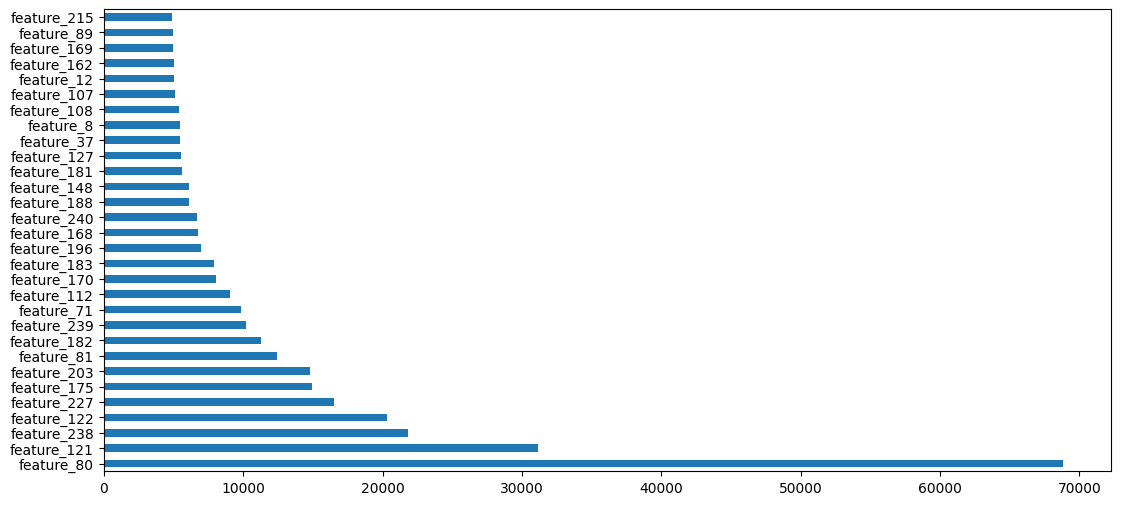

In [21]:
print('Feature_importance by LGBM Classifier:')
feat_importances = pd.Series(
    best_model.feature_importances_, index=df_train.drop(
        columns=['target', 'id']).columns
)
feat_importances.nlargest(30).plot(kind="barh", figsize=(13, 6))

Lets check for outliers and experiment with threshold movement

In [24]:
def find_outlier_threshold(df):
    '''
    THis function searches for optimal
    threshold for dropping outliers
    Threshold is a number by which we multiply interquartile distance

    '''
    best_score = 0
    best_threshold = 0
    for threshold in tqdm(range(10, 300, 20)):

        Q1 = df.quantile(0.25)
        Q3 = df.quantile(0.75)
        IQR = Q3 - Q1
        # Number of interquantile distances

        df_train_without_outliers = df[~(
            (df < (Q1 - threshold * IQR)) & (IQR != 0)).any(axis=1)]

        df_train_without_outliers = df[~(
            (df > (Q3 + threshold * IQR)) & (IQR != 0)).any(axis=1)]

        X_train, X_test, y_train, y_test = split_data(
            df_train_without_outliers)

        # Initialize the LightGBM Classifier
        best_model = lgb.LGBMClassifier(
            class_weight="balanced", importance_type="gain", n_jobs=-1, **parametres_)

        # Train the classifier on the entire dataset
        best_model.fit(X_train, y_train)

        y_pred = best_model.predict(X_test)

        # Calculate the macro-F1-score
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        if macro_f1 > best_score:
            best_score = macro_f1

            best_threshold = threshold

    print('Best score is:', best_score)
    print('Best threshold is:', best_threshold)
    return best_threshold

In [25]:
threshold = find_outlier_threshold(df_train)

100%|███████████████████████████████████████████| 15/15 [05:16<00:00, 21.09s/it]

Best score is: 0.5628469262851321
Best threshold is: 270


In [31]:
best_model = lgb.LGBMClassifier(
    class_weight="balanced", importance_type="gain", n_jobs=-1, **parametres_)
X_train, X_test, y_train, y_test = split_data(df_train)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)


macro_f1 = f1_score(y_test, y_pred, average='macro')
# Calculate the macro-F1-score
print('Overall f1-macro', macro_f1)
precision, recall, f1_score_, support = precision_recall_fscore_support(
    y_test, y_pred)
class_labels = best_model.classes_
for i in range(len(class_labels)):
    print(f"F1-Score for class {class_labels[i]}: {f1_score_[i]:.2f}")

Overall f1-macro 0.5756917430904065
F1-Score for class 0: 0.82
F1-Score for class 1: 0.37
F1-Score for class 2: 0.54


In [33]:
# Fitting the model for test predictions for test dataset

best_model = lgb.LGBMClassifier(
    class_weight="balanced", importance_type="gain", n_jobs=-1, **parametres_)

best_model.fit(df_train.drop(columns=['target', 'id']), df_train['target'])

LGBMClassifier(class_weight='balanced', colsample_bytree=0.7985005675497825,
               importance_type='gain', learning_rate=0.020120882485445236,
               min_child_samples=18, n_estimators=410, num_leaves=92,
               reg_alpha=0.19395485708076837, reg_lambda=0.1767091510357383)

Moving threshold does not improve the result, because we USE LGBM Classifier model

## Test predicting and saving resulting dataframe

In [43]:
df_test = preprocessing(df_test)

df_test = df_test[df_train.drop(columns='target').columns]

best_model.predict(df_test.drop(columns='id'))

contest_answer = pd.DataFrame(
    data={"ID": df_test['id'], "TARGET": best_model.predict(df_test.drop(columns='id'))})

print(contest_answer['TARGET'].value_counts())

contest_answer.to_csv("contest_answer.csv", index=False,
                      columns=["ID", "TARGET"])

0    4389
1    1289
2     453
Name: TARGET, dtype: int64


## Conclusion

In this notebook, we did:

 1. EDA
 2. Preprocessing (cleaning data from NaNs, duplicates, cleaning column names from symbols which conflict with LightGBM)
 3. Cleaning data from highly correlated featres and constants.
 4. Building a model using optuna optimization
 5. Oversampling and undersampling, with no result. Used built in 'class-weight = balanced'
 6. Permutation importance and importance gain techniques building to sort out most important and useless features. Found out that most important feature is feature_80. Dropped most useless with no result in metrics.
 7. Searching for best threshold and dropped outliers using it
 8. Using this model, making predictions for test dataset and saved them into a file.
 
We got a metric f1_macro : 0.5756. Comparing to baseline results of Dummy Classifier 0.3304,  result seems reasonable. But yet we perform poorly for class '1'

Model could be improved further:
    
    - Using cross_val_score instead of train_test_split.- We can use cross_val_score instead of train_test_split. We used train_test_split  for saving computing time
    
    - F1 score for classes 1 and 2 is performing not well. Building 2 models: first to tell 0 class from others, and second to tell 1  from 2 can work

    - Using LAMA to compare our results of optuna optimization with its inner algorythms that are more sophisticated that ours.

    - Experminting with keeping some columns with NaNs and putting plugs into them.
    
    - Using more sophisticated techniques to choose features, like generating random or adding one by one, or dropping one by one.
    
    - Searching for further insights in data.
    
    - Experimtenting with filling NaNs with Random Forrest
    
    - Experimenting with thresholds of correlation
    
    - Using more n_trials in optuna
    
    - Using shap values to interpret models

    - Moving big functions to separate file ".py